In [1]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk import tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# multiprocessing to speed up vader
from multiprocessing import Pool

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +           # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")            # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
analyzer = SentimentIntensityAnalyzer()

In [5]:
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('  ', hp[book][chapter][0])
        text = hp[book][chapter][1].replace('\n', '')
        sentence_list = tokenize.sent_tokenize(text)
        sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
        
        for sentence in sentence_list:
            vs = analyzer.polarity_scores(sentence)
            sentiments['compound'] += vs['compound']
            sentiments['neg'] += vs['neg']
            sentiments['neu'] += vs['neu']
            sentiments['pos'] += vs['pos']
            
        sentiments['compound'] = sentiments['compound'] / len(sentence_list)
        sentiments['neg'] = sentiments['neg'] / len(sentence_list)
        sentiments['neu'] = sentiments['neu'] / len(sentence_list)
        sentiments['pos'] = sentiments['pos'] / len(sentence_list)

        hp[book][chapter] = (hp[book][chapter][0], hp[book][chapter][1], sentiments)
    print()

Harry Potter and the Sorcerer's Stone
   THE BOY WHO LIVED
   THE VANISHING GLASS
   THE LETTERS FROM NO ONE
   THE KEEPER OF THE KEYS
   DIAGON ALLEY
   THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
   THE SORTING HAT
   THE POTIONS MASTER
   THE MIDNIGHT DUEL
   HALLOWEEN
   QUIDDITCH
   THE MIRROR OF ERISED
   NICHOLAS FLAMEL
   NORBERT THE NORWEGIAN RIDGEBACK
   THE FORBIDDEN FOREST
   THROUGH THE TRAPDOOR
   THE MAN WITH TWO FACES

Harry Potter and the Chamber of Secrets
   THE WORST BIRTHDAY
   DOBBY
   THE BURROW
   AT FLOURISH AND BLOTTS
   THE WHOMPING WILLOW
   GILDEROY LOCKHART
   MUDBLOODS AND MURMURS
   THE DEATHDAY PARTY
   THE WRITING ON THE WALL
   THE ROGUE BLUDGER
   THE DUELING CLUB
   THE POLYJUICE POTION
   THE VERY SECRET DIARY
   CORNELIUS FUDGE
   ARAGOG
   THE CHAMBER OF SECRETS
   THE HEIR OF SLYTHERIN

Harry Potter and the Prisoner of Azkaban
   OWL POST
   AUNT MARGE
   THE KNIGHT BUS
   THE LEAKY CAULDRON
   THE DEMENTOR
   TALONS AND TEA LEAVES
   THE 

In [6]:
compound_sentiments = [hp[book][chapter][2]['compound'] for book in hp for chapter in hp[book]]

In [7]:
chap = 0
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('  ', hp[book][chapter][0])
        print('     ', compound_sentiments[chap])
        chap += 1
    print()

Harry Potter and the Sorcerer's Stone
   THE BOY WHO LIVED
      0.035601173708920186
   THE VANISHING GLASS
      -0.018699275362318843
   THE LETTERS FROM NO ONE
      0.0008134502923976618
   THE KEEPER OF THE KEYS
      -0.02304878048780488
   DIAGON ALLEY
      0.04538205128205131
   THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
      0.026414975041597337
   THE SORTING HAT
      0.04281226666666667
   THE POTIONS MASTER
      0.023844499999999984
   THE MIDNIGHT DUEL
      -0.001744028103044498
   HALLOWEEN
      0.03709796511627909
   QUIDDITCH
      -0.0017154929577464844
   THE MIRROR OF ERISED
      0.03331609442060086
   NICHOLAS FLAMEL
      0.01425472972972973
   NORBERT THE NORWEGIAN RIDGEBACK
      0.012651219512195127
   THE FORBIDDEN FOREST
      -0.04717451737451737
   THROUGH THE TRAPDOOR
      0.02076897546897547
   THE MAN WITH TWO FACES
      0.016606188466947964

Harry Potter and the Chamber of Secrets
   THE WORST BIRTHDAY
      -0.007636651583710409
   DOBB

In [8]:
book_indices = {}
idx = 0
for book in hp:
    start = idx
    for chapter in hp[book]:
        idx += 1
    book_indices[book] = [start, idx-1]

In [9]:
book_indices

{'Harry Potter and the Chamber of Secrets': [17, 33],
 'Harry Potter and the Deathly Hallows': [157, 191],
 'Harry Potter and the Goblet of Fire': [56, 91],
 'Harry Potter and the Half-Blood Prince': [128, 156],
 'Harry Potter and the Order of the Phoenix': [92, 127],
 'Harry Potter and the Prisoner of Azkaban': [34, 55],
 "Harry Potter and the Sorcerer's Stone": [0, 16]}

In [10]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

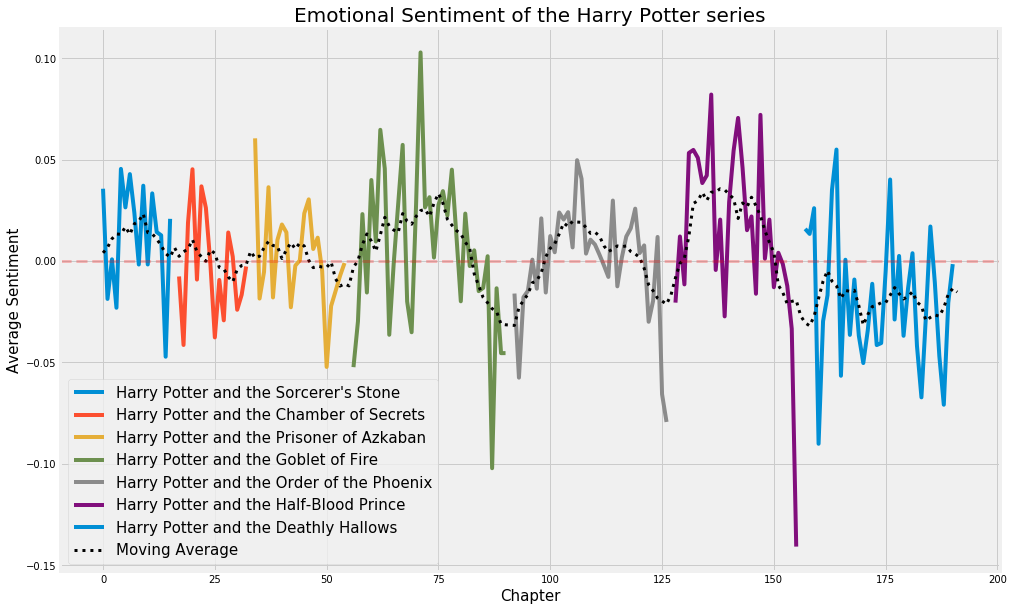

In [11]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)
y = [hp[book][chapter][2]['compound'] for book in hp for chapter in hp[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Emotional Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

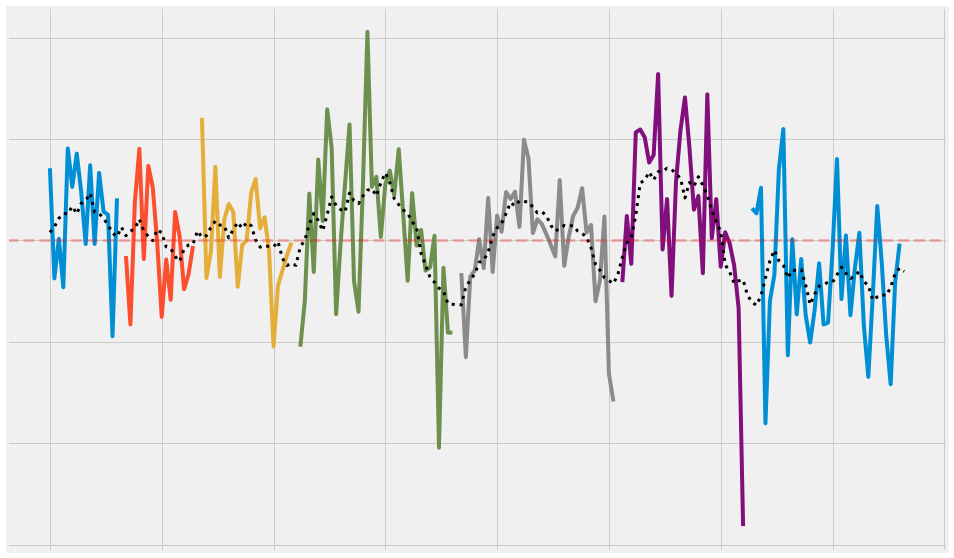

In [12]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)
y = [hp[book][chapter][2]['compound'] for book in hp for chapter in hp[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
# plt.legend(loc='best', fontsize=15)
plt.xticks(np.arange(0, 225, 25), '')
plt.yticks(np.arange(-.15, .15, .05), '')
plt.show()

In [13]:
sentiment_scores = [[hp[book][chapter][2][sentiment] for book in hp for chapter in hp[book]]
                    for sentiment in ['compound', 'neg', 'neu', 'pos']]

In [14]:
compound_sentiment = sentiment_scores[0]
print('Average Book Sentiment:')
print()
for book in book_indices:
    compound = compound_sentiment[book_indices[book][0]: book_indices[book][1]]
    print('{:45}{:.2f}%'.format(book, 100 * sum(compound) / len(compound)))
print('{:45}{:.2f}%'.format('Across the entire series', 100 * sum(compound_sentiment) / len(compound_sentiment)))

Average Book Sentiment:

Harry Potter and the Sorcerer's Stone        1.25%
Harry Potter and the Chamber of Secrets      -0.22%
Harry Potter and the Prisoner of Azkaban     0.20%
Harry Potter and the Goblet of Fire          0.53%
Harry Potter and the Order of the Phoenix    -0.04%
Harry Potter and the Half-Blood Prince       1.46%
Harry Potter and the Deathly Hallows         -1.81%
Across the entire series                     0.08%


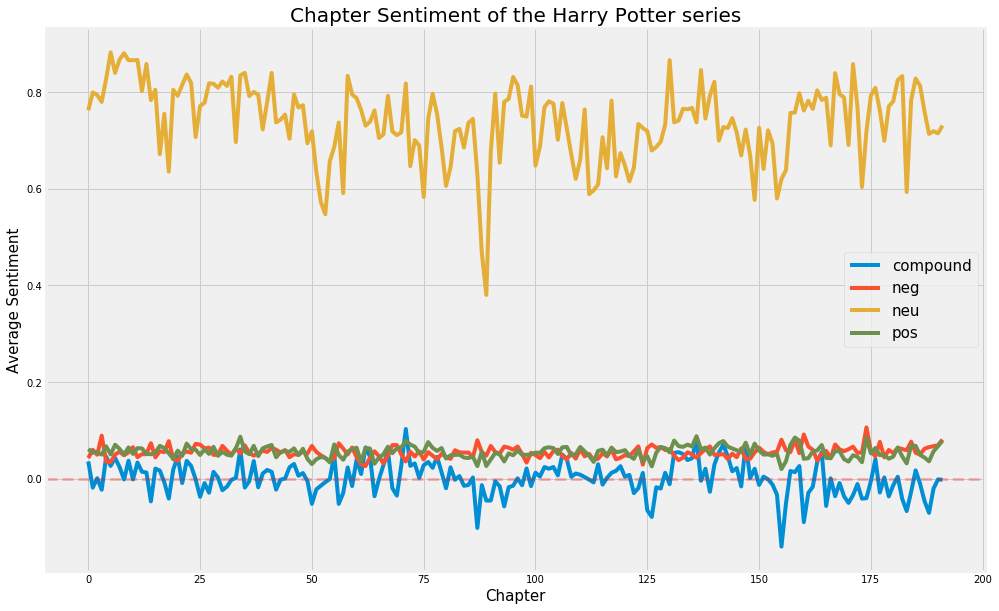

In [15]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 10))
for i, sentiment in enumerate(sentiment_scores):
    plt.plot(x,
             sentiment,
             label=['compound', 'neg', 'neu', 'pos'][i])
# plt.plot(movingaverage(compound_sentiments, 10)+.1, color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

# Testing - analyze whole chapter instead of average of sentences

In [16]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +               # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" +     # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                         # chapter title ends with lowercase letters or a period
           "(.*?)" +                                     # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")                # chapter contents ends with a new chapter or the end of book
hp2 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        hp2[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp2 = dict(hp2)

In [17]:
for book in hp2:
    print(book)
    for chapter in hp2[book]:
        print('  ', hp2[book][chapter][0])
        text = hp2[book][chapter][1].replace('\n', '')
        sentence_list = tokenize.sent_tokenize(text)
        sentiments2 = {'compound': [], 'neg': [], 'neu': [], 'pos': []}
        
        vs = analyzer.polarity_scores(text)
        sentiments2['compound'] = vs['compound']
        sentiments2['neg'] = vs['neg']
        sentiments2['neu'] = vs['neu']
        sentiments2['pos'] = vs['pos']

        hp2[book][chapter] = (hp2[book][chapter][0], hp2[book][chapter][1], sentiments2)
    print()

Harry Potter and the Sorcerer's Stone
   THE BOY WHO LIVED
   THE VANISHING GLASS
   THE LETTERS FROM NO ONE
   THE KEEPER OF THE KEYS
   DIAGON ALLEY
   THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
   THE SORTING HAT
   THE POTIONS MASTER
   THE MIDNIGHT DUEL
   HALLOWEEN
   QUIDDITCH
   THE MIRROR OF ERISED
   NICHOLAS FLAMEL
   NORBERT THE NORWEGIAN RIDGEBACK
   THE FORBIDDEN FOREST
   THROUGH THE TRAPDOOR
   THE MAN WITH TWO FACES

Harry Potter and the Chamber of Secrets
   THE WORST BIRTHDAY
   DOBBY
   THE BURROW
   AT FLOURISH AND BLOTTS
   THE WHOMPING WILLOW
   GILDEROY LOCKHART
   MUDBLOODS AND MURMURS
   THE DEATHDAY PARTY
   THE WRITING ON THE WALL
   THE ROGUE BLUDGER
   THE DUELING CLUB
   THE POLYJUICE POTION
   THE VERY SECRET DIARY
   CORNELIUS FUDGE
   ARAGOG
   THE CHAMBER OF SECRETS
   THE HEIR OF SLYTHERIN

Harry Potter and the Prisoner of Azkaban
   OWL POST
   AUNT MARGE
   THE KNIGHT BUS
   THE LEAKY CAULDRON
   THE DEMENTOR
   TALONS AND TEA LEAVES
   THE 

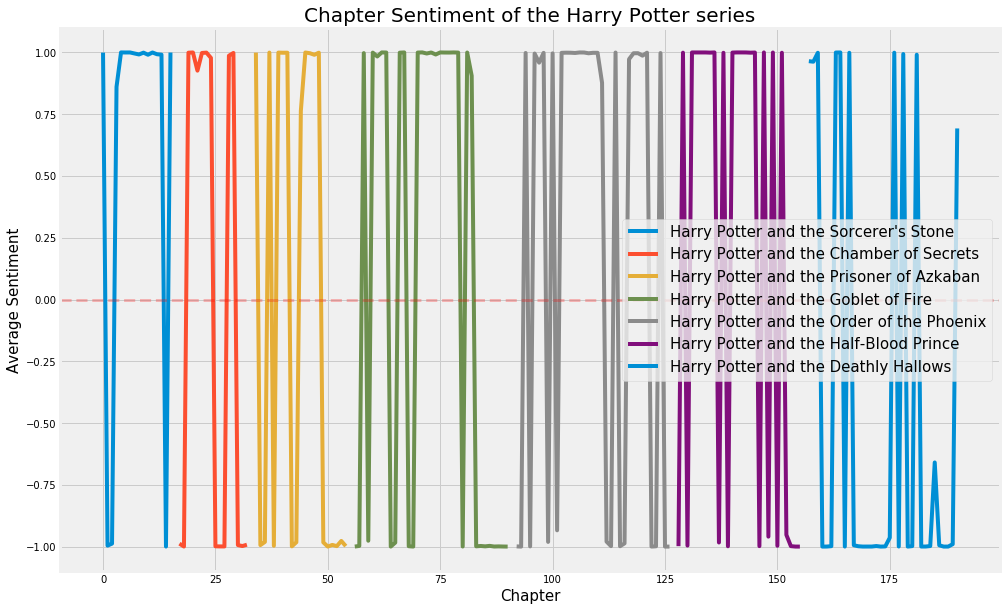

In [18]:
length = sum([len(hp2[book]) for book in hp2])
x = np.linspace(0, length - 1, num=length)
y = [hp2[book][chapter][2]['compound'] for book in hp2 for chapter in hp2[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
# plt.plot(movingaverage(y, 2), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

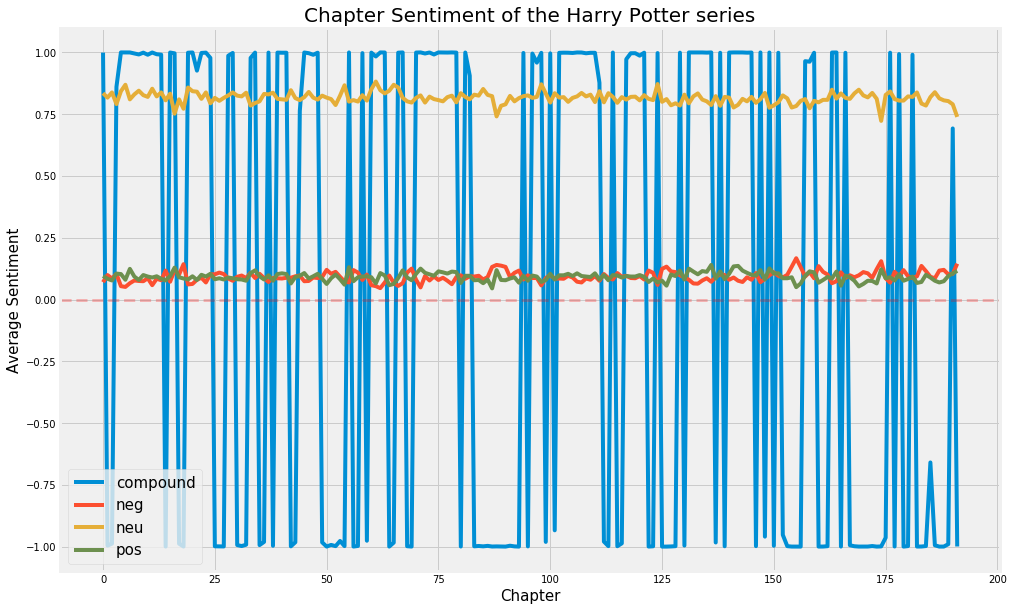

In [19]:
sentiment_scores2 = [[hp2[book][chapter][2][sentiment] for book in hp2 for chapter in hp2[book]]
                     for sentiment in ['compound', 'neg', 'neu', 'pos']]
length = sum([len(hp2[book]) for book in hp2])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 10))
for i, sentiment in enumerate(sentiment_scores2):
    plt.plot(x,
             sentiment,
             label=['compound', 'neg', 'neu', 'pos'][i])
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [20]:
compound_sentiment2 = sentiment_scores2[0]
print('Average Book Sentiment:')
print()
for book in book_indices:
    compound = compound_sentiment2[book_indices[book][0]: book_indices[book][1]]
    print('{:45}{:.2f}%'.format(book, 100 * sum(compound) / len(compound)))
print('{:45}{:.2f}%'.format('Across the entire series', 100 * sum(compound_sentiment2) / len(compound_sentiment2)))

Average Book Sentiment:

Harry Potter and the Sorcerer's Stone        61.47%
Harry Potter and the Chamber of Secrets      -0.53%
Harry Potter and the Prisoner of Azkaban     -5.51%
Harry Potter and the Goblet of Fire          8.35%
Harry Potter and the Order of the Phoenix    25.38%
Harry Potter and the Half-Blood Prince       21.82%
Harry Potter and the Deathly Hallows         -41.15%
Across the entire series                     5.99%


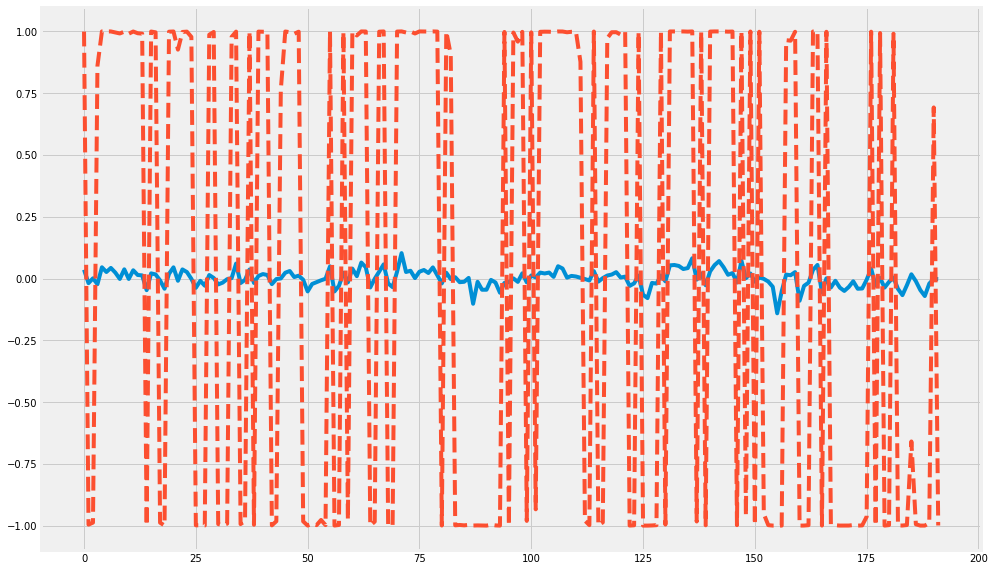

In [21]:
plt.figure(figsize=(15, 10))
plt.plot([hp[book][chapter][2]['compound'] for book in hp for chapter in hp[book]])
plt.plot([hp2[book][chapter][2]['compound'] for book in hp2 for chapter in hp2[book]], linestyle="--")
plt.show()

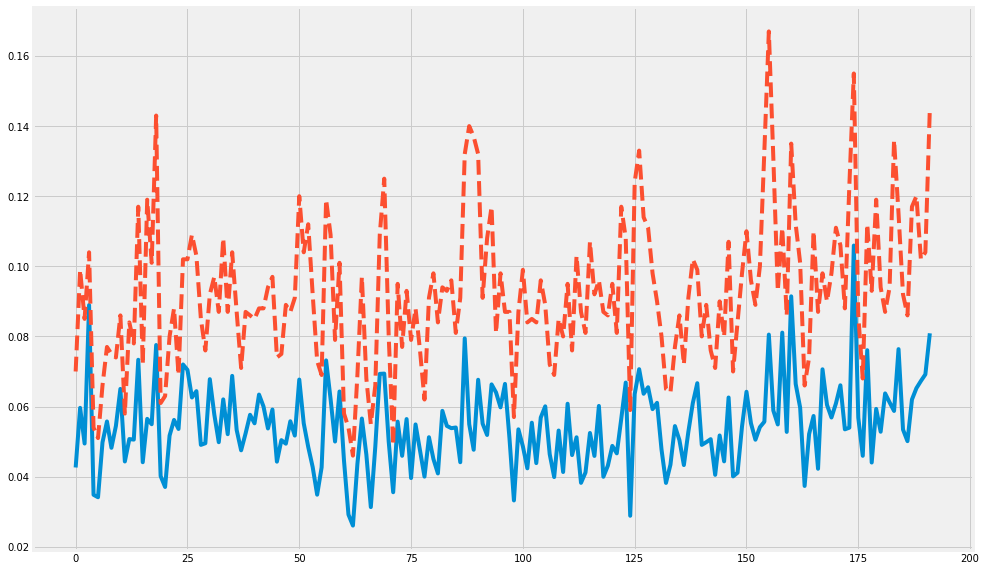

In [22]:
plt.figure(figsize=(15, 10))
plt.plot([hp[book][chapter][2]['neg'] for book in hp for chapter in hp[book]])
plt.plot([hp2[book][chapter][2]['neg'] for book in hp2 for chapter in hp2[book]], linestyle="--")
plt.show()

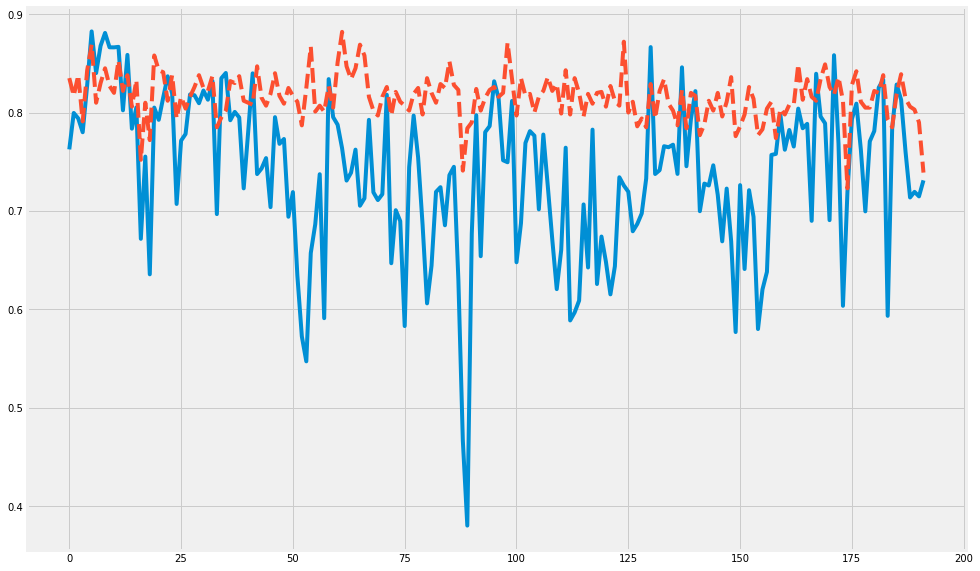

In [23]:
plt.figure(figsize=(15, 10))
plt.plot([hp[book][chapter][2]['neu'] for book in hp for chapter in hp[book]])
plt.plot([hp2[book][chapter][2]['neu'] for book in hp2 for chapter in hp2[book]], linestyle="--")
plt.show()

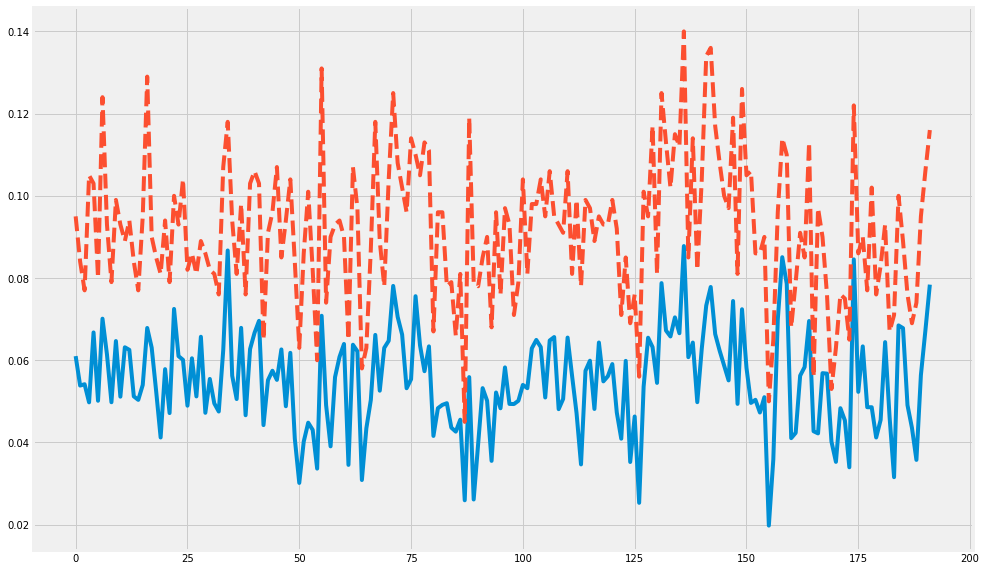

In [24]:
plt.figure(figsize=(15, 10))
plt.plot([hp[book][chapter][2]['pos'] for book in hp for chapter in hp[book]])
plt.plot([hp2[book][chapter][2]['pos'] for book in hp2 for chapter in hp2[book]], linestyle="--")
plt.show()

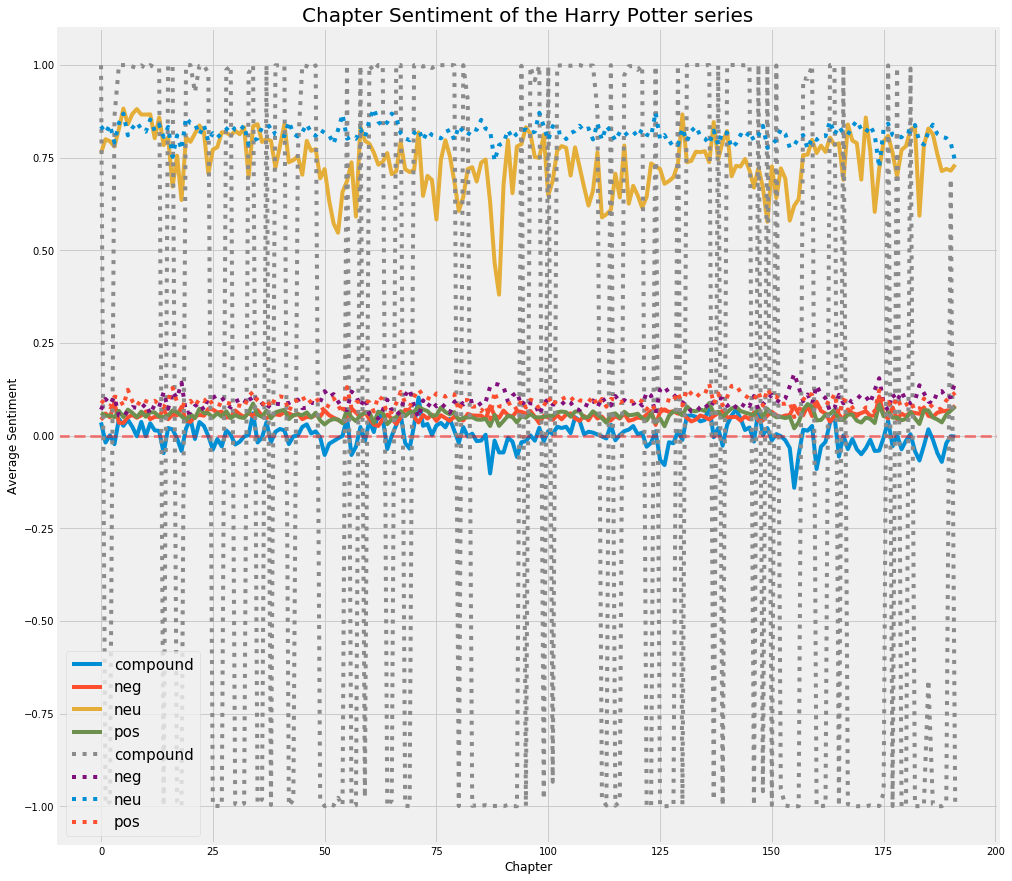

In [25]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 15))
for i, sentiment in enumerate(sentiment_scores):
    plt.plot(x,
             sentiment,
             label=['compound', 'neg', 'neu', 'pos'][i])
# plt.plot(movingaverage(compound_sentiments, 10)+.1, color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)




sentiment_scores2 = [[hp2[book][chapter][2][sentiment] for book in hp2 for chapter in hp2[book]] for sentiment in ['compound', 'neg', 'neu', 'pos']]
length = sum([len(hp2[book]) for book in hp2])
x = np.linspace(0, length - 1, num=length)

for i, sentiment in enumerate(sentiment_scores2):
    plt.plot(x,
             sentiment,
             label=['compound', 'neg', 'neu', 'pos'][i],
             linestyle=':')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter')
plt.ylabel('Average Sentiment')
plt.show()

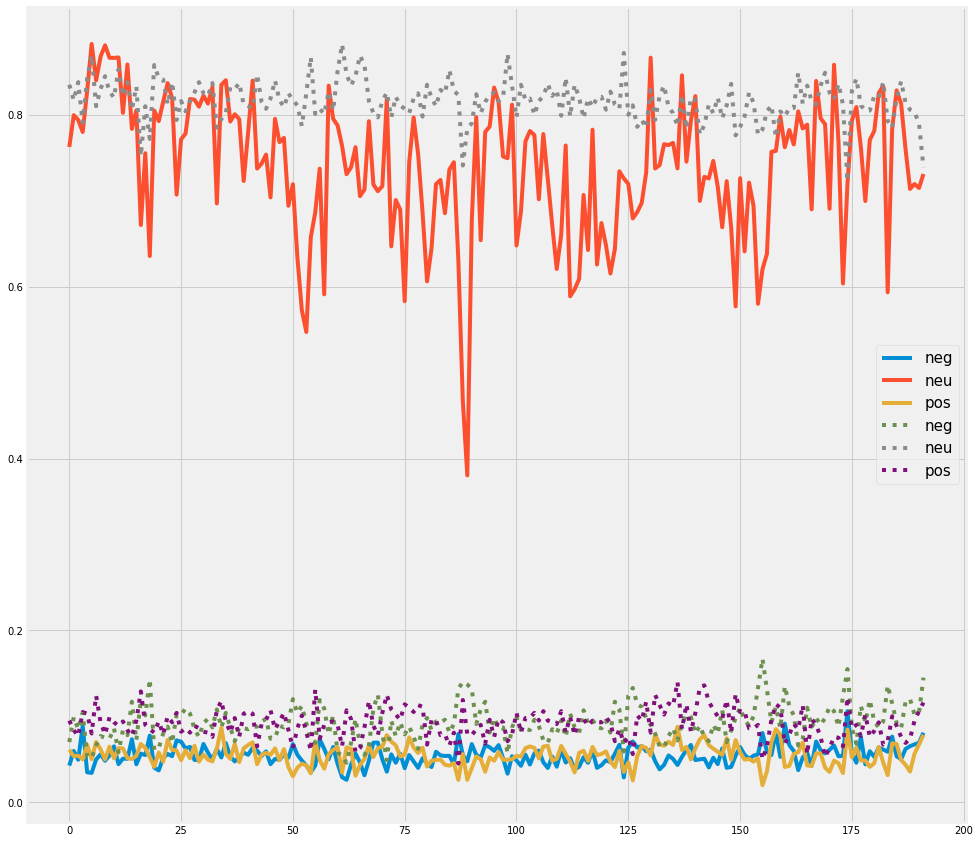

In [26]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

plt.figure(figsize=(15, 15))
for i, sentiment in enumerate(sentiment_scores[1:]):
    plt.plot(x,
             sentiment,
             label=['neg', 'neu', 'pos'][i])




sentiment_scores2 = [[hp2[book][chapter][2][sentiment] for book in hp2 for chapter in hp2[book]] for sentiment in ['compound', 'neg', 'neu', 'pos']]
length = sum([len(hp2[book]) for book in hp2])
x = np.linspace(0, length - 1, num=length)

for i, sentiment in enumerate(sentiment_scores2[1:]):
    plt.plot(x,
             sentiment,
             label=['neg', 'neu', 'pos'][i],
             linestyle=':')
plt.legend(loc='best', fontsize=15)
plt.show()

# Test TextBlob NaiveBayes and Pattern analyzers

In [27]:
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.sentiments import PatternAnalyzer

In [28]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +               # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" +     # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                         # chapter title ends with lowercase letters or a period
           "(.*?)" +                                     # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")                # chapter contents ends with a new chapter or the end of book
hp3 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        hp3[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp3 = dict(hp3)

In [29]:
nb = Blobber(analyzer=NaiveBayesAnalyzer())

In [30]:
for book in hp3:
    print(book)
    for chapter in hp3[book]:
        print('  ', hp3[book][chapter][0])
        text = hp3[book][chapter][1].replace('\n', '')
        sentence_list = tokenize.sent_tokenize(text)
        sentiments3 = 0
        
        for sentence in sentence_list:
            sentiments3 += nb(sentence).sentiment.p_pos * 2 - 1
            
        sentiments3 = sentiments3 / len(sentence_list)

        hp3[book][chapter] = (hp3[book][chapter][0], hp3[book][chapter][1], sentiments3 )
    print()

Harry Potter and the Sorcerer's Stone
   THE BOY WHO LIVED
   THE VANISHING GLASS
   THE LETTERS FROM NO ONE
   THE KEEPER OF THE KEYS
   DIAGON ALLEY
   THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
   THE SORTING HAT
   THE POTIONS MASTER
   THE MIDNIGHT DUEL
   HALLOWEEN
   QUIDDITCH
   THE MIRROR OF ERISED
   NICHOLAS FLAMEL
   NORBERT THE NORWEGIAN RIDGEBACK
   THE FORBIDDEN FOREST
   THROUGH THE TRAPDOOR
   THE MAN WITH TWO FACES

Harry Potter and the Chamber of Secrets
   THE WORST BIRTHDAY
   DOBBY
   THE BURROW
   AT FLOURISH AND BLOTTS
   THE WHOMPING WILLOW
   GILDEROY LOCKHART
   MUDBLOODS AND MURMURS
   THE DEATHDAY PARTY
   THE WRITING ON THE WALL
   THE ROGUE BLUDGER
   THE DUELING CLUB
   THE POLYJUICE POTION
   THE VERY SECRET DIARY
   CORNELIUS FUDGE
   ARAGOG
   THE CHAMBER OF SECRETS
   THE HEIR OF SLYTHERIN

Harry Potter and the Prisoner of Azkaban
   OWL POST
   AUNT MARGE
   THE KNIGHT BUS
   THE LEAKY CAULDRON
   THE DEMENTOR
   TALONS AND TEA LEAVES
   THE 

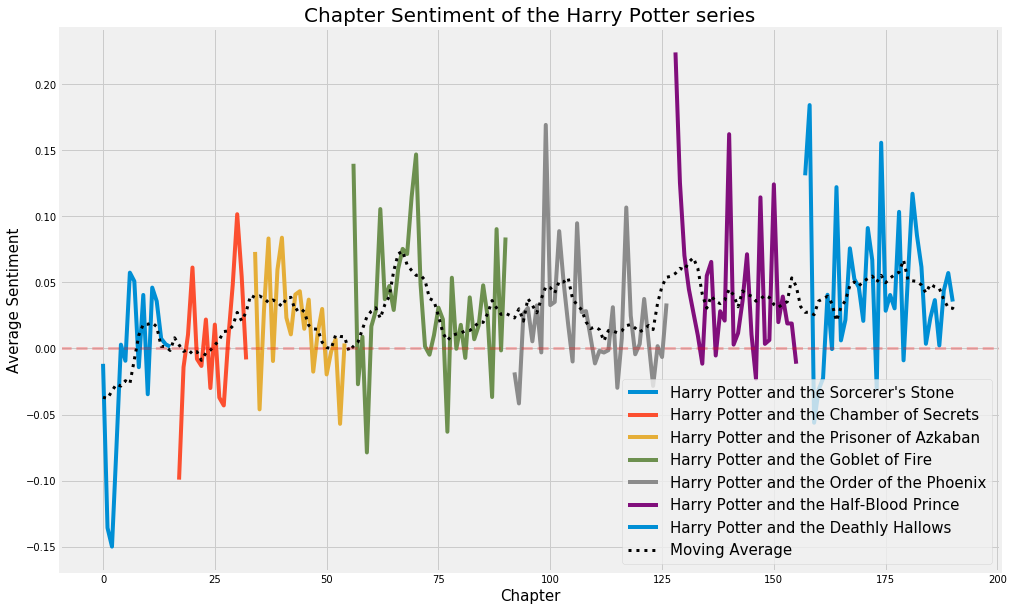

In [31]:
length = sum([len(hp3[book]) for book in hp3])
x = np.linspace(0, length - 1, num=length)
y = [hp3[book][chapter][2] for book in hp3 for chapter in hp3[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [32]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +               # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" +     # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                         # chapter title ends with lowercase letters or a period
           "(.*?)" +                                     # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")                # chapter contents ends with a new chapter or the end of book
hp4 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        hp4[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp4 = dict(hp4)

In [33]:
p = Blobber(analyzer=PatternAnalyzer())

In [34]:
for book in hp4:
    print(book)
    for chapter in hp4[book]:
        print('  ', hp4[book][chapter][0])
        text = hp4[book][chapter][1].replace('\n', '')
        sentence_list = tokenize.sent_tokenize(text)
        sentiments4 = 0
        
        for sentence in sentence_list:
            sentiments4 += p(sentence).sentiment.polarity
            
        sentiments4 = sentiments4 / len(sentence_list)

        hp4[book][chapter] = (hp4[book][chapter][0], hp4[book][chapter][1], sentiments4)
    print()

Harry Potter and the Sorcerer's Stone
   THE BOY WHO LIVED
   THE VANISHING GLASS
   THE LETTERS FROM NO ONE
   THE KEEPER OF THE KEYS
   DIAGON ALLEY
   THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
   THE SORTING HAT
   THE POTIONS MASTER
   THE MIDNIGHT DUEL
   HALLOWEEN
   QUIDDITCH
   THE MIRROR OF ERISED
   NICHOLAS FLAMEL
   NORBERT THE NORWEGIAN RIDGEBACK
   THE FORBIDDEN FOREST
   THROUGH THE TRAPDOOR
   THE MAN WITH TWO FACES

Harry Potter and the Chamber of Secrets
   THE WORST BIRTHDAY
   DOBBY
   THE BURROW
   AT FLOURISH AND BLOTTS
   THE WHOMPING WILLOW
   GILDEROY LOCKHART
   MUDBLOODS AND MURMURS
   THE DEATHDAY PARTY
   THE WRITING ON THE WALL
   THE ROGUE BLUDGER
   THE DUELING CLUB
   THE POLYJUICE POTION
   THE VERY SECRET DIARY
   CORNELIUS FUDGE
   ARAGOG
   THE CHAMBER OF SECRETS
   THE HEIR OF SLYTHERIN

Harry Potter and the Prisoner of Azkaban
   OWL POST
   AUNT MARGE
   THE KNIGHT BUS
   THE LEAKY CAULDRON
   THE DEMENTOR
   TALONS AND TEA LEAVES
   THE 

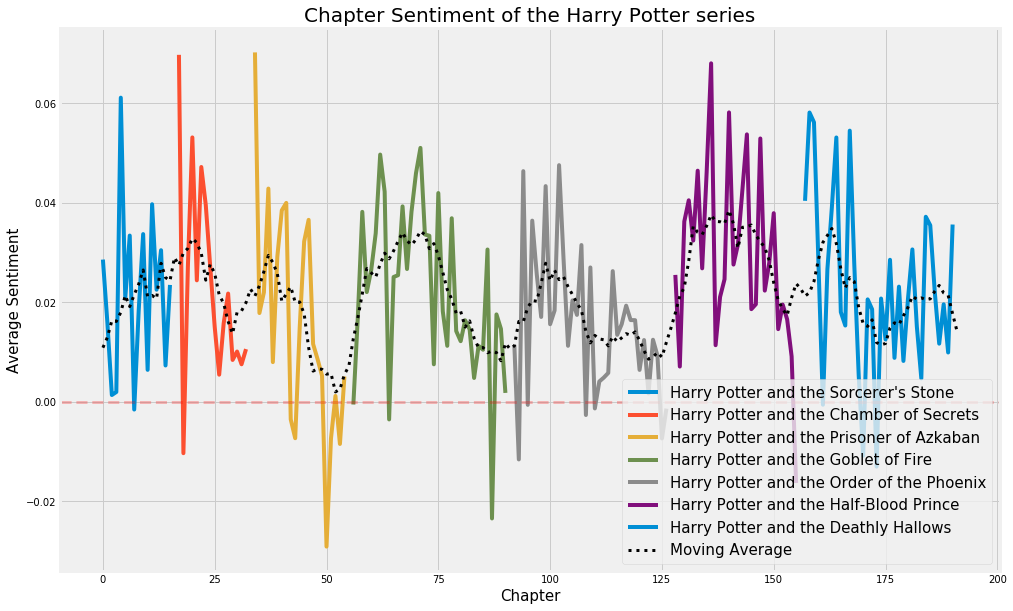

In [35]:
length = sum([len(hp4[book]) for book in hp4])
x = np.linspace(0, length - 1, num=length)
y = [hp4[book][chapter][2] for book in hp4 for chapter in hp4[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [36]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +               # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" +     # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                         # chapter title ends with lowercase letters or a period
           "(.*?)" +                                     # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")                # chapter contents ends with a new chapter or the end of book
hp5 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        hp5[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp5 = dict(hp5)

In [37]:
for book in hp5:
    print(book)
    for chapter in hp5[book]:
        print('  ', hp5[book][chapter][0])
        text = hp5[book][chapter][1].replace('\n', '')
        
        sentiment = nb(text).sentiment.p_pos * 2 - 1

        hp5[book][chapter] = (hp5[book][chapter][0], hp5[book][chapter][1], sentiment)
    print()

Harry Potter and the Sorcerer's Stone
   THE BOY WHO LIVED
   THE VANISHING GLASS
   THE LETTERS FROM NO ONE
   THE KEEPER OF THE KEYS
   DIAGON ALLEY
   THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
   THE SORTING HAT
   THE POTIONS MASTER
   THE MIDNIGHT DUEL
   HALLOWEEN
   QUIDDITCH
   THE MIRROR OF ERISED
   NICHOLAS FLAMEL
   NORBERT THE NORWEGIAN RIDGEBACK
   THE FORBIDDEN FOREST
   THROUGH THE TRAPDOOR
   THE MAN WITH TWO FACES

Harry Potter and the Chamber of Secrets
   THE WORST BIRTHDAY
   DOBBY
   THE BURROW
   AT FLOURISH AND BLOTTS
   THE WHOMPING WILLOW
   GILDEROY LOCKHART
   MUDBLOODS AND MURMURS
   THE DEATHDAY PARTY
   THE WRITING ON THE WALL
   THE ROGUE BLUDGER
   THE DUELING CLUB
   THE POLYJUICE POTION
   THE VERY SECRET DIARY
   CORNELIUS FUDGE
   ARAGOG
   THE CHAMBER OF SECRETS
   THE HEIR OF SLYTHERIN

Harry Potter and the Prisoner of Azkaban
   OWL POST
   AUNT MARGE
   THE KNIGHT BUS
   THE LEAKY CAULDRON
   THE DEMENTOR
   TALONS AND TEA LEAVES
   THE 

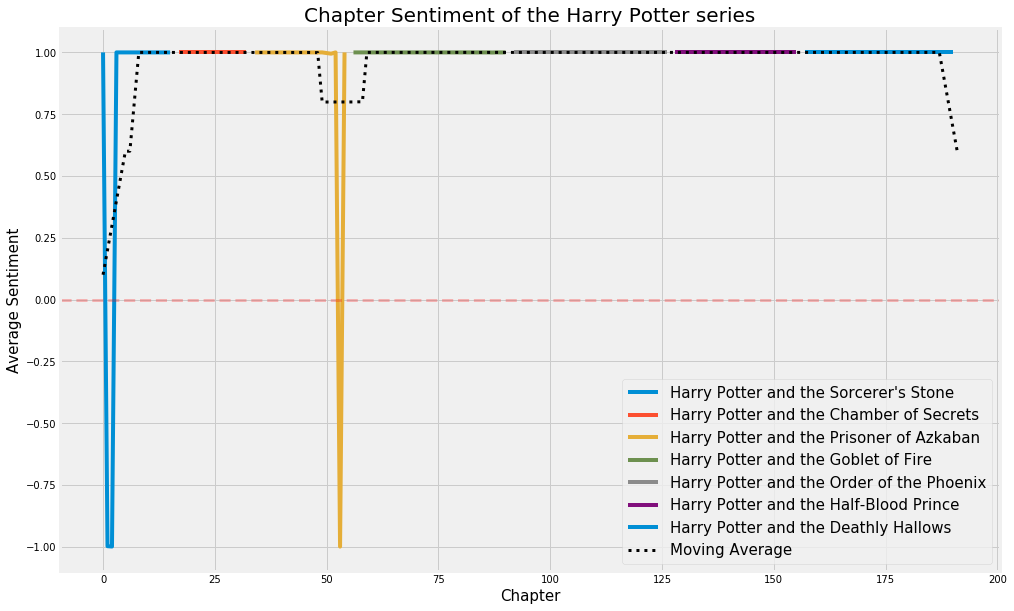

In [38]:
length = sum([len(hp5[book]) for book in hp5])
x = np.linspace(0, length - 1, num=length)
y = [hp5[book][chapter][2] for book in hp5 for chapter in hp5[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [39]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +               # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" +     # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                         # chapter title ends with lowercase letters or a period
           "(.*?)" +                                     # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")                # chapter contents ends with a new chapter or the end of book
hp6 = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        hp6[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp6 = dict(hp6)

In [40]:
for book in hp6:
    print(book)
    for chapter in hp6[book]:
        print('  ', hp6[book][chapter][0])
        text = hp6[book][chapter][1].replace('\n', '')
        
        sentiment = p(text).sentiment.polarity

        hp6[book][chapter] = (hp6[book][chapter][0], hp6[book][chapter][1], sentiment)
    print()

Harry Potter and the Sorcerer's Stone
   THE BOY WHO LIVED
   THE VANISHING GLASS
   THE LETTERS FROM NO ONE
   THE KEEPER OF THE KEYS
   DIAGON ALLEY
   THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS
   THE SORTING HAT
   THE POTIONS MASTER
   THE MIDNIGHT DUEL
   HALLOWEEN
   QUIDDITCH
   THE MIRROR OF ERISED
   NICHOLAS FLAMEL
   NORBERT THE NORWEGIAN RIDGEBACK
   THE FORBIDDEN FOREST
   THROUGH THE TRAPDOOR
   THE MAN WITH TWO FACES

Harry Potter and the Chamber of Secrets
   THE WORST BIRTHDAY
   DOBBY
   THE BURROW
   AT FLOURISH AND BLOTTS
   THE WHOMPING WILLOW
   GILDEROY LOCKHART
   MUDBLOODS AND MURMURS
   THE DEATHDAY PARTY
   THE WRITING ON THE WALL
   THE ROGUE BLUDGER
   THE DUELING CLUB
   THE POLYJUICE POTION
   THE VERY SECRET DIARY
   CORNELIUS FUDGE
   ARAGOG
   THE CHAMBER OF SECRETS
   THE HEIR OF SLYTHERIN

Harry Potter and the Prisoner of Azkaban
   OWL POST
   AUNT MARGE
   THE KNIGHT BUS
   THE LEAKY CAULDRON
   THE DEMENTOR
   TALONS AND TEA LEAVES
   THE 

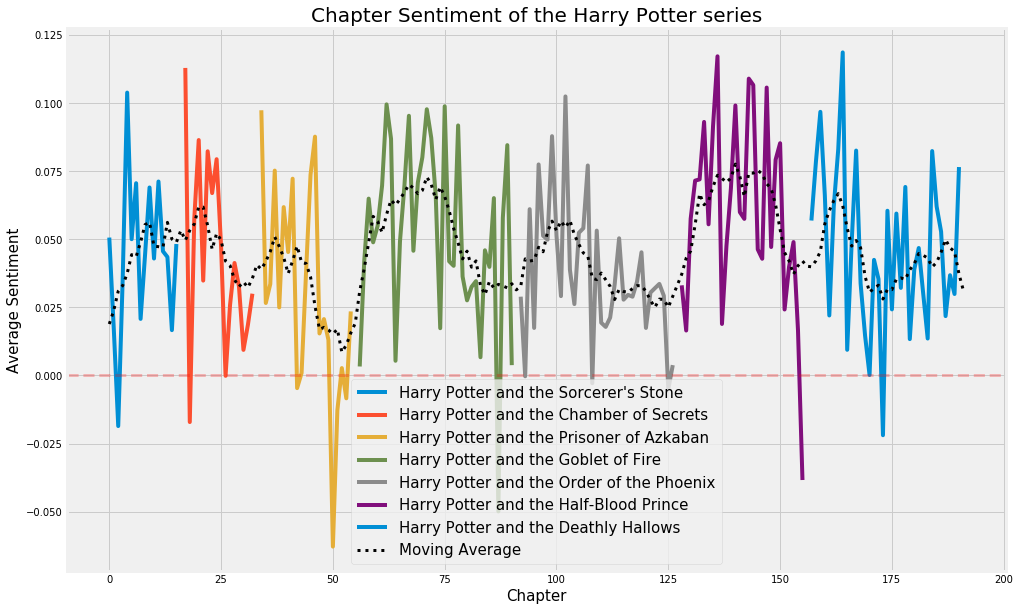

In [41]:
length = sum([len(hp6[book]) for book in hp6])
x = np.linspace(0, length - 1, num=length)
y = [hp6[book][chapter][2] for book in hp6 for chapter in hp6[book]]

plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=15)
plt.title('Chapter Sentiment of the Harry Potter series', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()